Задача: выяснить, от каких самых малоприбыльных рейсов из Анапы региональный филиал авиакомпании можем отказаться в зимнее время.

In [1]:
# Импортируем библеотеки 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from datetime import datetime, timedelta

In [2]:
# Загружаем данные, полученные в Metabase
data = pd.read_csv('.../data.csv')

In [4]:
data.sample(5)

,flight_id,model,scheduled_departure,departure_city,arrival_airport,arrival_city,seats,sold_seats,earnings,flight_time
82,136733,Sukhoi Superjet-100,2017-01-09T09:25:00Z,Anapa,EGO,Belgorod,97,94,746400.0,51.0
8,136159,Boeing 737-300,2017-01-04T10:05:00Z,Anapa,SVO,Moscow,130,115,1700600.0,98.0
94,136815,Sukhoi Superjet-100,2017-02-19T09:25:00Z,Anapa,EGO,Belgorod,97,97,765300.0,51.0
9,136164,Boeing 737-300,2017-01-07T10:05:00Z,Anapa,SVO,Moscow,130,120,1738400.0,99.0
23,136266,Boeing 737-300,2017-02-27T10:05:00Z,Anapa,SVO,Moscow,130,108,1566400.0,100.0


Для решения поставленной задачи в Metabase был получен датасет, содержащий информацию о рейсах из Анапы в знимнее время года. 
Данные включают в себя: id рейса, модель самолета, дату вылета, города вылета (Анапа), аэропорт прилета,
город прилета, количество мест в самолете, количество купленных мест, суммарную стоимость всех билетов на рейсе и 
затраченное время в полёте.

In [5]:
# В данных отсутствуют пропуски, больше половины данных строковые
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   flight_id            118 non-null    int64  
 1   model                118 non-null    object 
 2   scheduled_departure  118 non-null    object 
 3   departure_city       118 non-null    object 
 4   arrival_airport      118 non-null    object 
 5   arrival_city         118 non-null    object 
 6   seats                118 non-null    int64  
 7   sold_seats           118 non-null    int64  
 8   earnings             118 non-null    float64
 9   flight_time          118 non-null    float64
dtypes: float64(2), int64(3), object(5)
memory usage: 9.3+ KB


Самая простая модель оценки прибыльности: стоимость билетов - стоимость топлива на рейс. Для расчета стоимости топлива на рейс добавим в данные недостающие признаки, а именно: часовой расход топлива у самолета и стоимость топлива.

In [6]:
# В данных имеются две модели самолетов
data.model.unique()

array(['Boeing 737-300', 'Sukhoi Superjet-100'], dtype=object)

Часовой расход топлива у самолета Boeing 737-300 составляет 2400 кг/ч, а у самолета Sukhoi Superjet-100 - 1700 кг/ч. Характеристика времени полета самолета (flight_time) имеет размерность минут, переводя размерность расхода топлива в кг/мин, получаем 40.00 кг/мин и 28.33 кг/мин соответственно. Стоимость топлива ТС-1 в декабре 2017 составляет 47101 руб./т, в январе 2017 - 41435 руб./т, в феврале 2017 - 39553 руб./т. При переводе в нужные единицы измерения получаем: 47.10 руб./кг, 41.44 руб./кг и 39.55 руб./кг соответственно.

In [7]:
# Переведем столбец scheduled_departure в формат datetime
data.scheduled_departure = pd.to_datetime(data.scheduled_departure, format = '%Y-%m-%dT%H:%M:%SZ')

In [8]:
# Добавим новый признак - расход топлива 
data['fuel_consumption'] = data.model.apply(lambda x: 40.00 if x == 'Boeing 737-300' else 28.33 if 
                                                   x == 'Sukhoi Superjet-100' else x)

In [9]:
# Добавим новый признак - стоимость топлива в конкретный месяц
data['fuel_cost'] = data.scheduled_departure.apply(lambda x: 47.10 if x.month == 12 else 41.44 if 
                                                   x.month == 1 else 39.55 if x.month == 2 else x)

In [10]:
# Рассчитаем стоимость полета
data['flight_cost'] = data['flight_time'] * data['fuel_consumption'] * data['fuel_cost']

In [11]:
# Рассчитаем итоговый признак - прибыльность
data['profit'] = data['earnings'] - data['flight_cost']

In [12]:
data['profit'].max()

1720240.0

In [13]:
data['profit'].mean()

1066796.2106050833

In [14]:
data['profit'].min()

473474.2352

Как видно, отрицательных значений в колонке profit нет, но разница между максимумом и минимумом достаточно существенная.

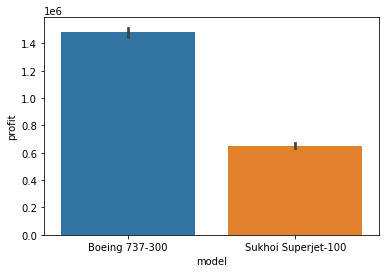

In [15]:
# Рассмотрим прибыль в зависимости от модели самолета
sns.barplot(x = "model", y = "profit", data = data)

Как видно из рисунка выше, больше прибыли приносят самолеты Boeing 737-300. 

In [16]:
# Узнаем сколько прибыли приходится на одно место в самолете.
data['profit_per_seat'] = data['profit'] / data['sold_seats']

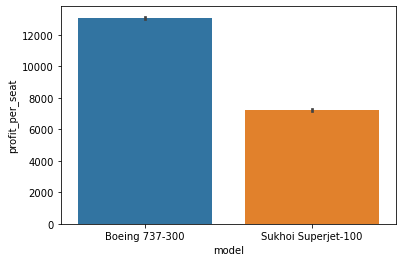

In [17]:
sns.barplot(x = "model", y = "profit_per_seat", data = data)

Видно, что место в самолете Boeing 737-300 лучше окупается. Посмотрим, летает ли одина модель самолета в один город или в разные.

In [18]:
data[data.model == 'Boeing 737-300']['arrival_city'].unique()

array(['Moscow'], dtype=object)

In [19]:
data[data.model == 'Sukhoi Superjet-100']['arrival_city'].unique()

array(['Belgorod'], dtype=object)

Одна модель самолета соответствует одному городу

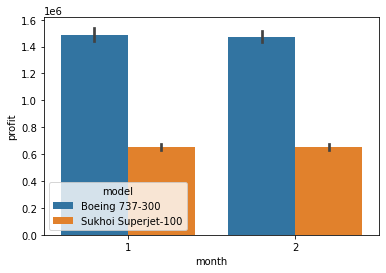

In [20]:
# Рассмотрим распределение прибыли по месяцам
data['month'] = data.scheduled_departure.dt.month
sns.barplot(x = 'month', y = 'profit', data = data, hue = 'model')

In [21]:
data[data.month == 1].arrival_airport.value_counts()

SVO    31
EGO    31
Name: arrival_airport, dtype: int64

In [22]:
data[data.month == 2].arrival_airport.value_counts()

SVO    28
EGO    28
Name: arrival_airport, dtype: int64

При одинаковом количестве рейсов в Москву и Белгород мы получаем разную прибыть, так происходит в основном потому, что в Белгород летит меньше людей, нежели чем в Москву, так как количество мест в самолете Sukhoi Superjet-100 меньше и меньше мест продано. Для увеличения прибыли авиакомпании можно попробовать пустить рейсы и в другие крупные города страны, например, в Санкт-Петербург.

In [23]:
a = data[(data.month == 1) & (data.model == 'Sukhoi Superjet-100')].seats.sum()
b = data[(data.month == 1) & (data.model == 'Sukhoi Superjet-100')].sold_seats.sum()
c = data[(data.month == 2) & (data.model == 'Sukhoi Superjet-100')].seats.sum()
d = data[(data.month == 2) & (data.model == 'Sukhoi Superjet-100')].sold_seats.sum()
print(a-b, c-d)

208 194


Разница между общим количеством мест во всех самолетах, летящих в Белгород в январе, и количеством проданных мест равна 208. Учитывая, что в одном самолете 97 мест, можно отказаться от двух рейсов. В феврале сумма непроданных мест численно точно равна общему количеству мест в двух самолетах Sukhoi Superjet-100, что так же говорит о том, что можно отказаться от двух ресов.

In [24]:
a = data[(data.month == 1) & (data.model == 'Boeing 737-300')].seats.sum()
b = data[(data.month == 1) & (data.model == 'Boeing 737-300')].sold_seats.sum()
c = data[(data.month == 2) & (data.model == 'Boeing 737-300')].seats.sum()
d = data[(data.month == 2) & (data.model == 'Boeing 737-300')].sold_seats.sum()
print(a-b, c-d)

499 497


С рейсами, летящими в Мосвку, похожая ситуация, не все самолеты заполнены, в первом и втором месяце можно отказаться минимум от 3 рейсов (в одном самолете 130 мест). 
Если мы откажемся от 4 рейсов, тогда не будут куплен 21 билет, если допустить, что это билеты эконом класса, тогда 21 * 12200 = 256200 руб будут потеряны. В итоге в январе в Москву будет совершено 27 рейсов с полной вместимостью, и общая выручка составит 46446480 рублей (количество рейсов умножаем на профит от полностью заполненного самолета). 
Если отказаться от 3 ресов, то останутся незаполненными 109 мест. Допустим будет совершено 27 рейсов, где самолеты будут полностью заполнены, то есть прибыль составит, как и в предыдущем случае, составит 46446480 руб, а на последний рейс был куплен только 21 билет. Вычтем от прибыли от покупки 21 билета расход топлива самолетом в январе, получаем 256200 - 165760 = 90440 рублей, именно столько составит профит от самолета Boeing, в котором летит только 21 человек. 
Получается, что отменить только 3 рейса будет выгоднее. Аналогичный вывод получается и для рейсов в феврале.
(Вывод сделан без учета расходов на оплату персонала и др.)

In [25]:
data['day'] = data.scheduled_departure.dt.day

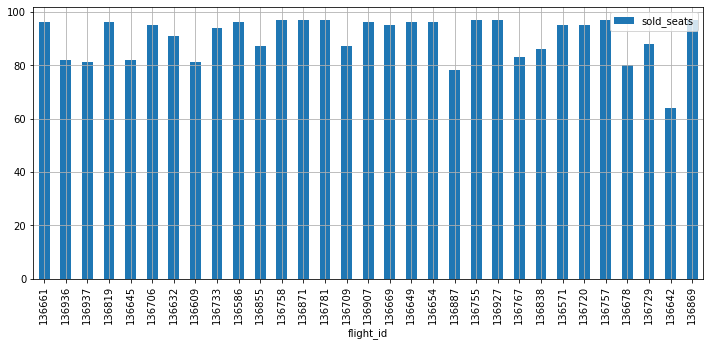

In [26]:
# Найдем самые малоприбыльные рейсы в Белгород в январе
(data[(data.month == 1) & (data.model == 'Sukhoi Superjet-100')].sort_values("day")).plot(x = 'flight_id', 
                                                                                          y = 'sold_seats', 
                                                                                          kind = 'bar', 
                                                                                          grid = True, 
                                                                                          figsize=(12,5))

Отсортировав данные по дням видно, что самолеты в певрые и последние дни января менее загружены, таким образом можно убрать рейс 136937, вылетающий 3 января, и рейс 136642, вылетающий 30 января.

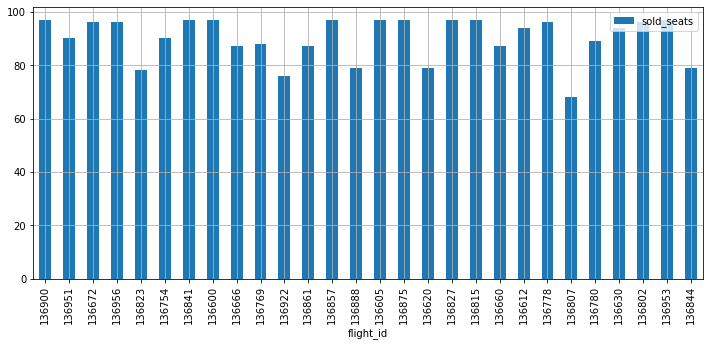

In [27]:
# Найдем самые малоприбыльные рейсы в Белгород в феврале
(data[(data.month == 2) & (data.model == 'Sukhoi Superjet-100')].sort_values("day")).plot(x = 'flight_id', 
                                                                                          y = 'sold_seats', 
                                                                                          kind = 'bar', 
                                                                                          grid = True, 
                                                                                          figsize=(12,5))

В феврале можно отказаться от рейса 136823 от 5 февраля и от рейса 136807 (23 февряля).

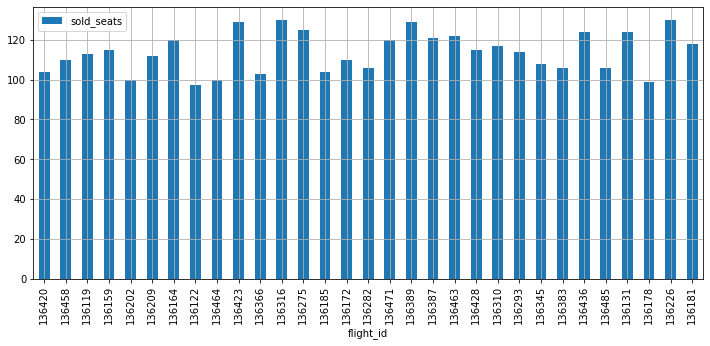

In [28]:
# Найдем самые малоприбыльные рейсы в Москву в январе
(data[(data.month == 1) & (data.model == 'Boeing 737-300')].sort_values("day")).plot(x = 'flight_id', 
                                                                                     y = 'sold_seats', 
                                                                                     kind = 'bar', 
                                                                                     grid = True, 
                                                                                     figsize=(12,5))

Здесь можно отказаться от рейсов: 136420 (1 января), 136122 (8 января) и 136178 (29 января) 

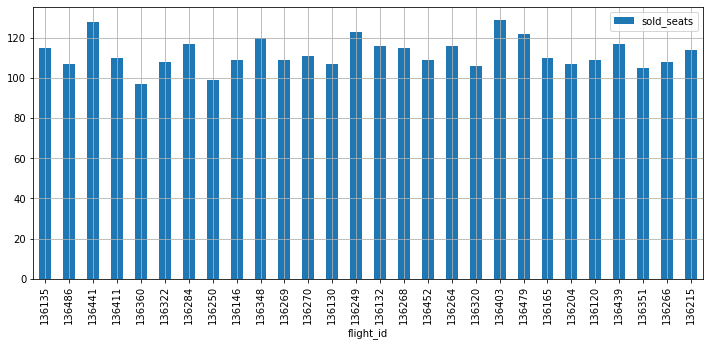

In [29]:
# Найдем самые малоприбыльные рейсы в Москву в феврале
(data[(data.month == 2) & (data.model == 'Boeing 737-300')].sort_values("day")).plot(x = 'flight_id', 
                                                                                     y = 'sold_seats', 
                                                                                     kind = 'bar', 
                                                                                     grid = True, 
                                                                                     figsize=(12,5))

В феврале малоприбыльными рейсами будут 136360 (5 февраля), 136250 (8 февраля) и 136351 (26 февраля).

В результате точечных выделении наиболее "пустых" рейсов была замечена закономерность, что такие рейсы встречаются в основном в начале и в конце месяца, что говорит о том, что авиакомпания может сокращать какое-то количество рейсов именно в эти периоды.

Вывод

Задачей данного проекта было выяснить, от каких самых малоприбыльных рейсов из Анапы авиакомпания может отказаться в зимнее время. В ходе работы в Metabase был собран датасет из внутренних данных, в котором содержалась необходимая для решения задачи информация, а именно: id рейса, модель самолета, дату вылета, города вылета (Анапа), аэропорт прилета, город прилета, количество мест в самолете, количество купленных мест, суммарную стоимость всех билетов на рейсе и затраченное время в полёте. Далее для расчета профита от рейса были добавлены данные о расходе топлива самолетом и стоимости топлива в конкретный период. Из анализа получившихся данных стало ясно, что рейсы в Москву лучше окупаются, при том, что количество рейсов одинаковое, поэтому авиакомпания может повысить свои доходы, если будет добавлять рейсы в другие крупные города страны, например, в Санкт-Петербург. Для сокращения расходов компании было предложено решение, которое подразумевает сокращение наиболее "пустых" рейсов, чаще всего такие рейсы бывают в начале и в конце месяца. В январе предлжено убрать рейсы 136937 и 136642, вылетающие в Белгород, и рейсы 136420, 136122, 136178, вылетающие в Москву. В феврале - рейсы 136823 и 136807, вылетающие в Белгород, и рейсы 136360, 136250 и 136351, вылетающие в Москву.